In [29]:
# importação das bibliotecas necessarias

from spacy.lang.pt import STOP_WORDS
import pandas as pd 
import numpy as np
import seaborn as sns
import string
import spacy 
import random

# ignorar os warnings de depreciação de metodos
import warnings
warnings.simplefilter("ignore")

In [30]:
# carregamento da base de dados

treino = pd.read_csv('./data/base_treinamento.txt')
teste = pd.read_csv('./data/base_teste.txt')

In [31]:
# primeiros registros

treino.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [32]:
# primeiros registros teste

teste.head()

,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria


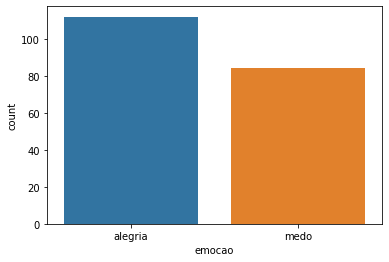

In [33]:
# visualização dos grupos ['emocao']

sns.countplot(treino['emocao'], label='Contagem');

In [34]:
# pre processamento de texto

In [35]:
# pontuações 

pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
# stop_words

stop_words = STOP_WORDS

In [37]:
# modelo em portugues

pln = spacy.load('pt')
pln

In [38]:
def processamento(text):
    
    text = text.lower()                  # todos em minuscula para evitar problemas com a lematização
    documento = pln(text)
    lista = []

    # lematização
    for token in documento:
        #lista.append(token.text)
        lista.append(token.lemma_)

    #remoção de stop_words
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

    return lista


In [39]:
teste = processamento('Estou aprendendo liguagem natural com python, em brasilia')
teste

'aprender liguagem natural python brasilia'

In [40]:
# pre processamento da base dados

In [41]:
# visualização da base de dados

treino.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [42]:
# provessamento na base de dados

treino['texto'] = treino['texto'].apply(processamento)

In [43]:
# visualização após o tratamento

treino.head()

,texto,emocao
0,trabalhar agradável,alegria
1,gostar ficar o aconchegar,alegria
2,o adesão o o cursar hoje,alegria
3,admirar,alegria
4,adorar comer,alegria


In [44]:
# tratamento das classes

In [45]:
exemplo_base_dados =[['este trabalho é agradavel', {'ALEGRIA':True, 'MEDO':False}],
                     'este lugar continua assustador', {'ALEGRIA':False, 'MEDO':True}]            

In [46]:
exemplo_base_dados[0]

['este trabalho é agradavel', {'ALEGRIA': True, 'MEDO': False}]

In [47]:
exemplo_base_dados[0][0]

'este trabalho é agradavel'

In [48]:
exemplo_base_dados[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [49]:
type(exemplo_base_dados[0][1])

dict

In [50]:
# deixar a base de dados como no exemplo

In [51]:
treino['emocao']

0      alegria
1      alegria
2      alegria
3      alegria
4      alegria
        ...   
191       medo
192       medo
193       medo
194       medo
195       medo
Name: emocao, Length: 196, dtype: object

In [52]:
# processamento da base de dados

base_dados_final = []

for texto, emocao in zip(treino['texto'], treino['emocao']):
    #print(texto, emocao)
    if emocao == 'alegria':
        dic = ({'ALEGRIA':True, 'MEDO':False})
    elif emocao == 'medo':
        dic = ({'ALEGRIA':False, 'MEDO':True})
    
    base_dados_final.append([texto, dic.copy()])

In [53]:
# verificação após tratamento

base_dados_final[0]

['trabalhar agradável', {'ALEGRIA': True, 'MEDO': False}]

In [54]:
base_dados_final[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [55]:
type(base_dados_final[0][1])

dict

In [56]:
# criação do classificador

In [57]:
# configurações do modelo

model = spacy.blank('pt')

categorias = model.create_pipe('textcat')
categorias.add_label('ALEGRIA')
categorias.add_label('MEDO')

model.add_pipe(categorias)

historico = []

In [61]:
model.begin_training()

for epoch in range(1_000):
    random.shuffle(base_dados_final)
    losses = {}
    
    for batch in spacy.util.minibatch(base_dados_final, 30):  # quantos registros a atualização dos pesos
        
        textos = [model(texto) for texto, entities in batch]
        
        annotations = [{'cats': entities} for texto, entities in batch]
        
        # atualização dos pesos
        model.update(textos, annotations, losses=losses)
    
    if epoch % 100 == 0:
        print(losses)
        historico.append(losses)


{'textcat': 8.3414576690366e-08}
{'textcat': 1.1711246625245586e-09}
